In [1]:
!pip install finance-datareader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from PIL import Image
import random

day_num = 32

In [4]:
def convert_image(data, num_images, day_num, name, code, save = False):

    def alpha_blend(color1, color2, alpha):
        return [
            int((color1[0] * alpha + color2[0] * (1 - alpha))),
            int((color1[1] * alpha + color2[1] * (1 - alpha))),
            int((color1[2] * alpha + color2[2] * (1 - alpha)))
        ]
    if len(data) < day_num + 20:
        print("종목 데이터 부족")
        return []

    if num_images > len(data) - day_num + 1 - 20:
        num_images = len(data) - day_num + 1 - 20


    return_datas = []
    image_idx = 1
    while(image_idx <= num_images):

        if image_idx != 1:
            stock_data = data[-image_idx - day_num + 1 : -image_idx + 1]
        else:
            stock_data = data[-day_num:]
        # 이미지 크기 설정
        width, height = day_num * 3, 96

        # High, Low, Close, Volume 데이터 정규화
        # high_prices = stock_data['High'].values
        # low_prices = stock_data['Low'].values
        open_prices = stock_data['Open'].values
        close_prices = stock_data['Close'].values

        # high_prices_norm = (high_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        # low_prices_norm = (low_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))

        high_prices = max(close_prices.max(), open_prices.max())
        low_prices = min(close_prices.min(), open_prices.min())
        open_prices_norm = (open_prices - low_prices) / (high_prices - low_prices)
        close_prices_norm = (close_prices - low_prices) / (high_prices - low_prices)

        if len(data) <= abs(-image_idx - day_num - 18):
            break

        # 이동평균선 추가를 위한 stock_data 생성
        if image_idx != 1:
            stock_data_ma20 = data[-image_idx - day_num - 18: -image_idx + 1]
        else:
            stock_data_ma20 = data[-image_idx - day_num - 18: ]

        stock_data_ma20 = stock_data_ma20.copy()
        stock_data_ma20['MA20'] = stock_data_ma20['Close'].rolling(window=20).mean()
        stock_data_ma20.dropna(inplace=True)

        # 이동평균선 값을 정규화
        stock_data_ma20['MA20_norm'] = (
                (stock_data_ma20['MA20'] - low_prices) / (high_prices - low_prices)
            )


        # 96x96 이미지 생성
        img = np.zeros((height, width, 3), dtype=np.uint8)  # 3 channels for RGB

        fail_generate = False
        for day in range(day_num):
            # high_price = int(high_prices_norm[day] * (height - 1))
            # low_price = int(low_prices_norm[day] * (height - 1))
            close_price = int(close_prices_norm[day] * (height - 1))
            open_price = int(open_prices_norm[day] * (height - 1))

            x_start = day * 3

            # 시가, 종가, 고가, 저가 막대그래프
            # 막대 왼쪽, 오른쪽 그리기 (시가, 종가 범위)
            for x in range(x_start, x_start + 3):
                if close_prices[day] > stock_data['Open'].values[day]:
                    color = [255, 0, 0]  # 상승: 빨강
                    tail_color = [200, 0, 0]  # 상승 시 꼬리: 어두운 빨강
                elif close_prices[day] < stock_data['Open'].values[day]:
                    color = [0, 0, 255]  # 하락: 파랑
                    tail_color = [0, 0, 200]  # 하락 시 꼬리: 어두운 파랑
                else: # 시가와 종가가 같을경우 어제보다 같거나 올랐으면 빨강, 아니면 파랑
                    if 0 <= stock_data['Change'].values[day]:
                        color = [255, 0, 0]  # 상승: 빨강
                        tail_color = [200, 0, 0]  # 상승 시 꼬리: 어두운 빨강
                    else:
                        color = [0, 0, 255]  # 하락: 파랑
                        tail_color = [0, 0, 200]  # 하락 시 꼬리: 어두운 파랑

                for y in range(min(open_price, close_price), max(open_price, close_price) + 1):
                    img[height - 1 - y, x] = color

            # 꼬리 그리기 (High, Low 범위)
            # for x in range(x_start + 1, x_start + 2):
            #     for y in range(low_price, high_price + 1):
            #         if img[height - 1 - y, x][0] != 255 and img[height - 1 - y, x][2] != 255:
            #             img[height - 1 - y, x] = tail_color

            # 20일 이동평균선 그리기
            ma20_norm = stock_data_ma20.iloc[day]['MA20_norm']

            for x in range(x_start, x_start + 3):
                if not np.isnan(ma20_norm):
                    ma20_y = int(ma20_norm * (height - 1))
                    if 0 <= ma20_y < height:
                        for y in range(ma20_y - 1, ma20_y + 2):  # 이동평균선 주변에 블렌딩 처리
                            if 0 <= y < height:
                                new_color = alpha_blend([255, 255, 0], img[height - 1 - y, x], 0.4)  # 노란색으로 변경
                                img[height - 1 - y, x] = new_color

        #이미지가 day_num(그려지기 원하는 거래일 수)미만으로 그려졌으면
        if fail_generate:
            image_idx += 1
            continue

        if save :
            # 이미지 저장
            nimg = Image.fromarray(img, 'RGB')
            nimg.save(f'stock_data_image_{image_idx}.png')


        return_datas.append((img, name, code, stock_data.index[-1]))

        image_idx += 1


    return return_datas

In [5]:
def preprocess_data(data):
    # 0이나 NaN을 포함하는 행 제거
    data = data[data['Volume'] != 0]
    data = data.dropna(how='any')

    return data

In [6]:
class StockData:
    def __init__(self, open_prices, close_prices, high_prices, low_prices, name, code, date):
        self.open_prices = open_prices
        self.close_prices = close_prices
        self.high_prices = high_prices
        self.low_prices = low_prices
        self.name = name
        self.code = code
        self.date = date

In [7]:
RIGHT_QUARTILE = 8 # 맨 마지막 종가를 몇분위로 나눌건지
LEFT_QUARTILE = 8
# open_close_data = [[[[] for _ in range(day_num)] for _ in range(RIGHT_QUARTILE)] for _ in range(day_num)]

def convert_norm(data, num_images, day_num, name, code, save=False):
    global open_close_data

    if len(data) < day_num:
        print("종목 데이터 부족")
        if save:
            return 0
        else:
            return [[-1, -1, -1, -1, -1]]

    if num_images > len(data) - day_num + 1:
        num_images = len(data) - day_num + 1

    return_data = []
    image_idx = 1
    cnt = 0
    while(image_idx <= num_images):

        if image_idx != 1:
            stock_data = data[-image_idx - day_num + 1 : -image_idx + 1]
        else:
            stock_data = data[-day_num:]

        open_prices = stock_data['Open'].values
        close_prices = stock_data['Close'].values

        highest_prices = max(close_prices.max(), open_prices.max())
        lowest_prices = min(close_prices.min(), open_prices.min())
        open_prices_norm = (open_prices - lowest_prices) / (highest_prices - lowest_prices)
        close_prices_norm = (close_prices - lowest_prices) / (highest_prices - lowest_prices)

        max_idx = day_num
        min_idx = day_num
        first_close_idx = min(np.digitize(close_prices_norm[-1], np.linspace(0, 1, LEFT_QUARTILE + 1)) - 1, LEFT_QUARTILE - 1)
        last_close_idx = min(np.digitize(close_prices_norm[-1], np.linspace(0, 1, RIGHT_QUARTILE + 1)) - 1, RIGHT_QUARTILE - 1)
        # for i in range(day_num):
        #     if open_prices_norm[i] == 0 or close_prices_norm[i] == 0:
        #         min_idx = i
        #     if open_prices_norm[i] == 1 or close_prices_norm[i] == 1:
        #         max_idx = i

        high_prices = stock_data['High'].values
        low_prices = stock_data['Low'].values

        highest_prices = high_prices.max()
        lowest_prices = low_prices.min()
        high_prices_norm = (high_prices - lowest_prices) / (highest_prices - lowest_prices)
        low_prices_norm = (low_prices - lowest_prices) / (highest_prices - lowest_prices)
        for i in range(day_num):
            if low_prices_norm[i] == 0:
                min_idx = i
            if high_prices_norm[i] == 1:
                max_idx = i

        image_idx += random.choice(range(1,4))
        cnt += 1
        if save:
            open_close_data[max_idx][last_close_idx][min_idx][first_close_idx].append(StockData(open_prices_norm, close_prices_norm, high_prices_norm, low_prices_norm, name, code, str(stock_data.index[-1])[:10]))
        else:
            return_data.append([max_idx, last_close_idx, min_idx, first_close_idx, StockData(open_prices_norm, close_prices_norm, high_prices_norm, low_prices_norm, name, code, str(stock_data.index[-1])[:10])])

    if save:
        return cnt
    else:
        return return_data

In [8]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/codes.csv', usecols=[0, 1], dtype={0: str})
# 첫 번째 열과 두 번째 열을 Nx2 리스트로 변환
stock_codes = df.values.tolist()

# 결과 출력
print(stock_codes)

[['095570', 'AJ네트웍스'], ['006840', 'AK홀딩스'], ['054620', 'APS'], ['265520', 'AP시스템'], ['211270', 'AP위성'], ['027410', 'BGF'], ['282330', 'BGF리테일'], ['126600', 'BGF에코머티리얼즈'], ['138930', 'BNK금융지주'], ['001460', 'BYC'], ['001465', 'BYC우'], ['013720', 'CBI'], ['083790', 'CG인바이츠'], ['001040', 'CJ'], ['079160', 'CJ CGV'], ['035760', 'CJ ENM'], ['311690', 'CJ 바이오사이언스'], ['00104K', 'CJ4우(전환)'], ['000120', 'CJ대한통운'], ['011150', 'CJ씨푸드'], ['011155', 'CJ씨푸드1우'], ['001045', 'CJ우'], ['097950', 'CJ제일제당'], ['097955', 'CJ제일제당 우'], ['051500', 'CJ프레시웨이'], ['058820', 'CMG제약'], ['023460', 'CNH'], ['056730', 'CNT85'], ['000480', 'CR홀딩스'], ['065770', 'CS'], ['083660', 'CSA 코스믹'], ['000590', 'CS홀딩스'], ['012030', 'DB'], ['404950', 'DB금융스팩10호'], ['456440', 'DB금융스팩11호'], ['367360', 'DB금융스팩9호'], ['016610', 'DB금융투자'], ['005830', 'DB손해보험'], ['000990', 'DB하이텍'], ['139130', 'DGB금융지주'], ['060900', 'DGP'], ['025440', 'DH오토웨어'], ['001530', 'DI동일'], ['000210', 'DL'], ['001880', 'DL건설'], ['000215', 'DL우'], ['375500', 'DL이앤씨'

In [ ]:
open_close_data = [[[[[] for _ in range(LEFT_QUARTILE)] for _ in range(day_num)] for _ in range(RIGHT_QUARTILE)] for _ in range(day_num)]
def process():
    global open_close_data
    cnt_sum = 0
    for i, ticker in enumerate(stock_codes):
        code, name = ticker[0], ticker[1]
        print(f"{i+1}번째 종목 {name} 추출중...   ")

        try:
            stock_data = preprocess_data(fdr.DataReader(code, '2013-01-01'))  # 각 종목의 데이터 가져오기
            cnt = convert_norm(stock_data, 3000, day_num, name, code, save=True)
            cnt_sum += cnt
            print(f"{cnt}개 추출 / 총{cnt_sum}개")

        except IndexError:
            print(f"{name}에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.")
            continue

process()

1번째 종목 AJ네트웍스 추출중...   
985개 추출 / 총985개
2번째 종목 AK홀딩스 추출중...   
1304개 추출 / 총2289개
3번째 종목 APS 추출중...   
1296개 추출 / 총3585개
4번째 종목 AP시스템 추출중...   
799개 추출 / 총4384개
5번째 종목 AP위성 추출중...   
913개 추출 / 총5297개
6번째 종목 BGF 추출중...   
1131개 추출 / 총6428개
7번째 종목 BGF리테일 추출중...   
688개 추출 / 총7116개
8번째 종목 BGF에코머티리얼즈 추출중...   
1326개 추출 / 총8442개
9번째 종목 BNK금융지주 추출중...   
1293개 추출 / 총9735개
10번째 종목 BYC 추출중...   
1293개 추출 / 총11028개
11번째 종목 BYC우 추출중...   
1316개 추출 / 총12344개
12번째 종목 CBI 추출중...   
1277개 추출 / 총13621개
13번째 종목 CG인바이츠 추출중...   
1315개 추출 / 총14936개
14번째 종목 CJ 추출중...   
1329개 추출 / 총16265개
15번째 종목 CJ CGV 추출중...   
1324개 추출 / 총17589개
16번째 종목 CJ ENM 추출중...   
1301개 추출 / 총18890개
17번째 종목 CJ 바이오사이언스 추출중...   
457개 추출 / 총19347개
18번째 종목 CJ4우(전환) 추출중...   
497개 추출 / 총19844개
19번째 종목 CJ대한통운 추출중...   
1321개 추출 / 총21165개
20번째 종목 CJ씨푸드 추출중...   
1321개 추출 / 총22486개
21번째 종목 CJ씨푸드1우 추출중...   
1296개 추출 / 총23782개
22번째 종목 CJ우 추출중...   
1318개 추출 / 총25100개
23번째 종목 CJ제일제당 추출중...   
1293개 추출 / 총26393개
24번째 종목 CJ제일제당 우 추출중...   


In [ ]:
import pickle

with open("drive/MyDrive/Colab Notebooks/a.pkl", "wb") as f:
    pickle.dump(open_close_data, f)

# with open("drive/MyDrive/Colab Notebooks/a.pkl", "rb") as f:
#     open_close_data = pickle.load(f)

In [ ]:
import numpy as np
from scipy.spatial.distance import cosine
import heapq

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

similar = {code : [] for code, name in stock_codes}  # 유사한 이미지들을 저장할 리스트

cnt = 0
for code, name in stock_codes[:1]:
    up, right, down, left, latest_data = convert_norm(preprocess_data(fdr.DataReader(code, '2023-03-01')), 1, day_num, name, code)[0]
    if up == -1:
        continue

    for u in range(max(up - 1, 0), min(up + 2, day_num)):
        for r in range(max(right - 1, 0), min(right + 2, RIGHT_QUARTILE)):
            for d in range(max(down - 1, 0), min(down + 2, day_num)):
                for l in range(max(left - 1, 0), min(right + 2, LEFT_QUARTILE)):
                    for data in open_close_data[u][r][d][l]:
                        # dif = (1 - cosine(latest_data.open_prices, data.open_prices)) + (1 - cosine(latest_data.close_prices, data.close_prices)) + (1 - cosine(latest_data.high_prices, data.high_prices)) + (1 - cosine(latest_data.low_prices, data.low_prices))
                        dif = rmse(latest_data.open_prices, data.open_prices) + rmse(latest_data.close_prices, data.close_prices) + rmse(latest_data.high_prices, data.high_prices) + rmse(latest_data.low_prices, data.low_prices)
                        # (유사도 음수값, 데이터) 형태로 힙에 추가합니다.
                        heapq.heappush(similar[code], (-dif, data))

                        # similar 리스트의 크기가 100을 초과하면 가장 작은 원소(즉, 유사도가 가장 낮은 원소)를 제거합니다.
                        if len(similar[code]) > 100:
                            heapq.heappop(similar[code])


    for i in range(len(similar[code])):
        dif = similar[code][i][0]
        data = similar[code][i][1]
        dif += ((1 - cosine(latest_data.open_prices, data.open_prices)) + (1 - cosine(latest_data.close_prices, data.close_prices)))
        similar[code][i] = (dif, data)

    similar[code].sort(reverse=True)

    cnt += 1
    print(cnt, name)
print(similar['095570'])

1 AJ네트웍스
[(4, <__main__.StockData object at 0x7f2ab703dc00>), (3.864790556230892, <__main__.StockData object at 0x7f2a6bdf6470>), (3.833058742924689, <__main__.StockData object at 0x7f2a79ae53f0>), (3.832701678430996, <__main__.StockData object at 0x7f2ab1a8d8d0>), (3.830976627345173, <__main__.StockData object at 0x7f2a7cb91cf0>), (3.827407508968958, <__main__.StockData object at 0x7f2a9bf27640>), (3.823957188849479, <__main__.StockData object at 0x7f2a8477e710>), (3.822749766635175, <__main__.StockData object at 0x7f2aa5b3dcf0>), (3.8172182859396298, <__main__.StockData object at 0x7f2a82061c90>), (3.8162257634482017, <__main__.StockData object at 0x7f2ab2967730>), (3.8148426461766545, <__main__.StockData object at 0x7f2a8d359690>), (3.8144141419494835, <__main__.StockData object at 0x7f2a92d4e4d0>), (3.8136955610640024, <__main__.StockData object at 0x7f2aa16c36a0>), (3.8136898453917447, <__main__.StockData object at 0x7f2aa4353ac0>), (3.8109600475748393, <__main__.StockData object 

In [ ]:
from datetime import datetime, timedelta

similar_images = {code : [] for code, name in stock_codes}
for code, name in stock_codes[:1]:
    for dif, data in similar[code]:
        date_obj = datetime.strptime(data.date, '%Y-%m-%d')

        # 1년 이전의 날짜 계산
        one_year_ago = date_obj - timedelta(days=120)

        # 다시 문자열로 변환
        one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')
        stock_data = preprocess_data(fdr.DataReader(data.code, one_year_ago_str, data.date))  # 각 종목의 데이터 가져오기
        image = convert_image(stock_data, 1, day_num, data.name, data.code)
        if len(image) == 0:
            continue
        data.image = image[0][0]
        similar_images[code].append((dif, data))
        print(len(similar_images[code]))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
종목 데이터 부족
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


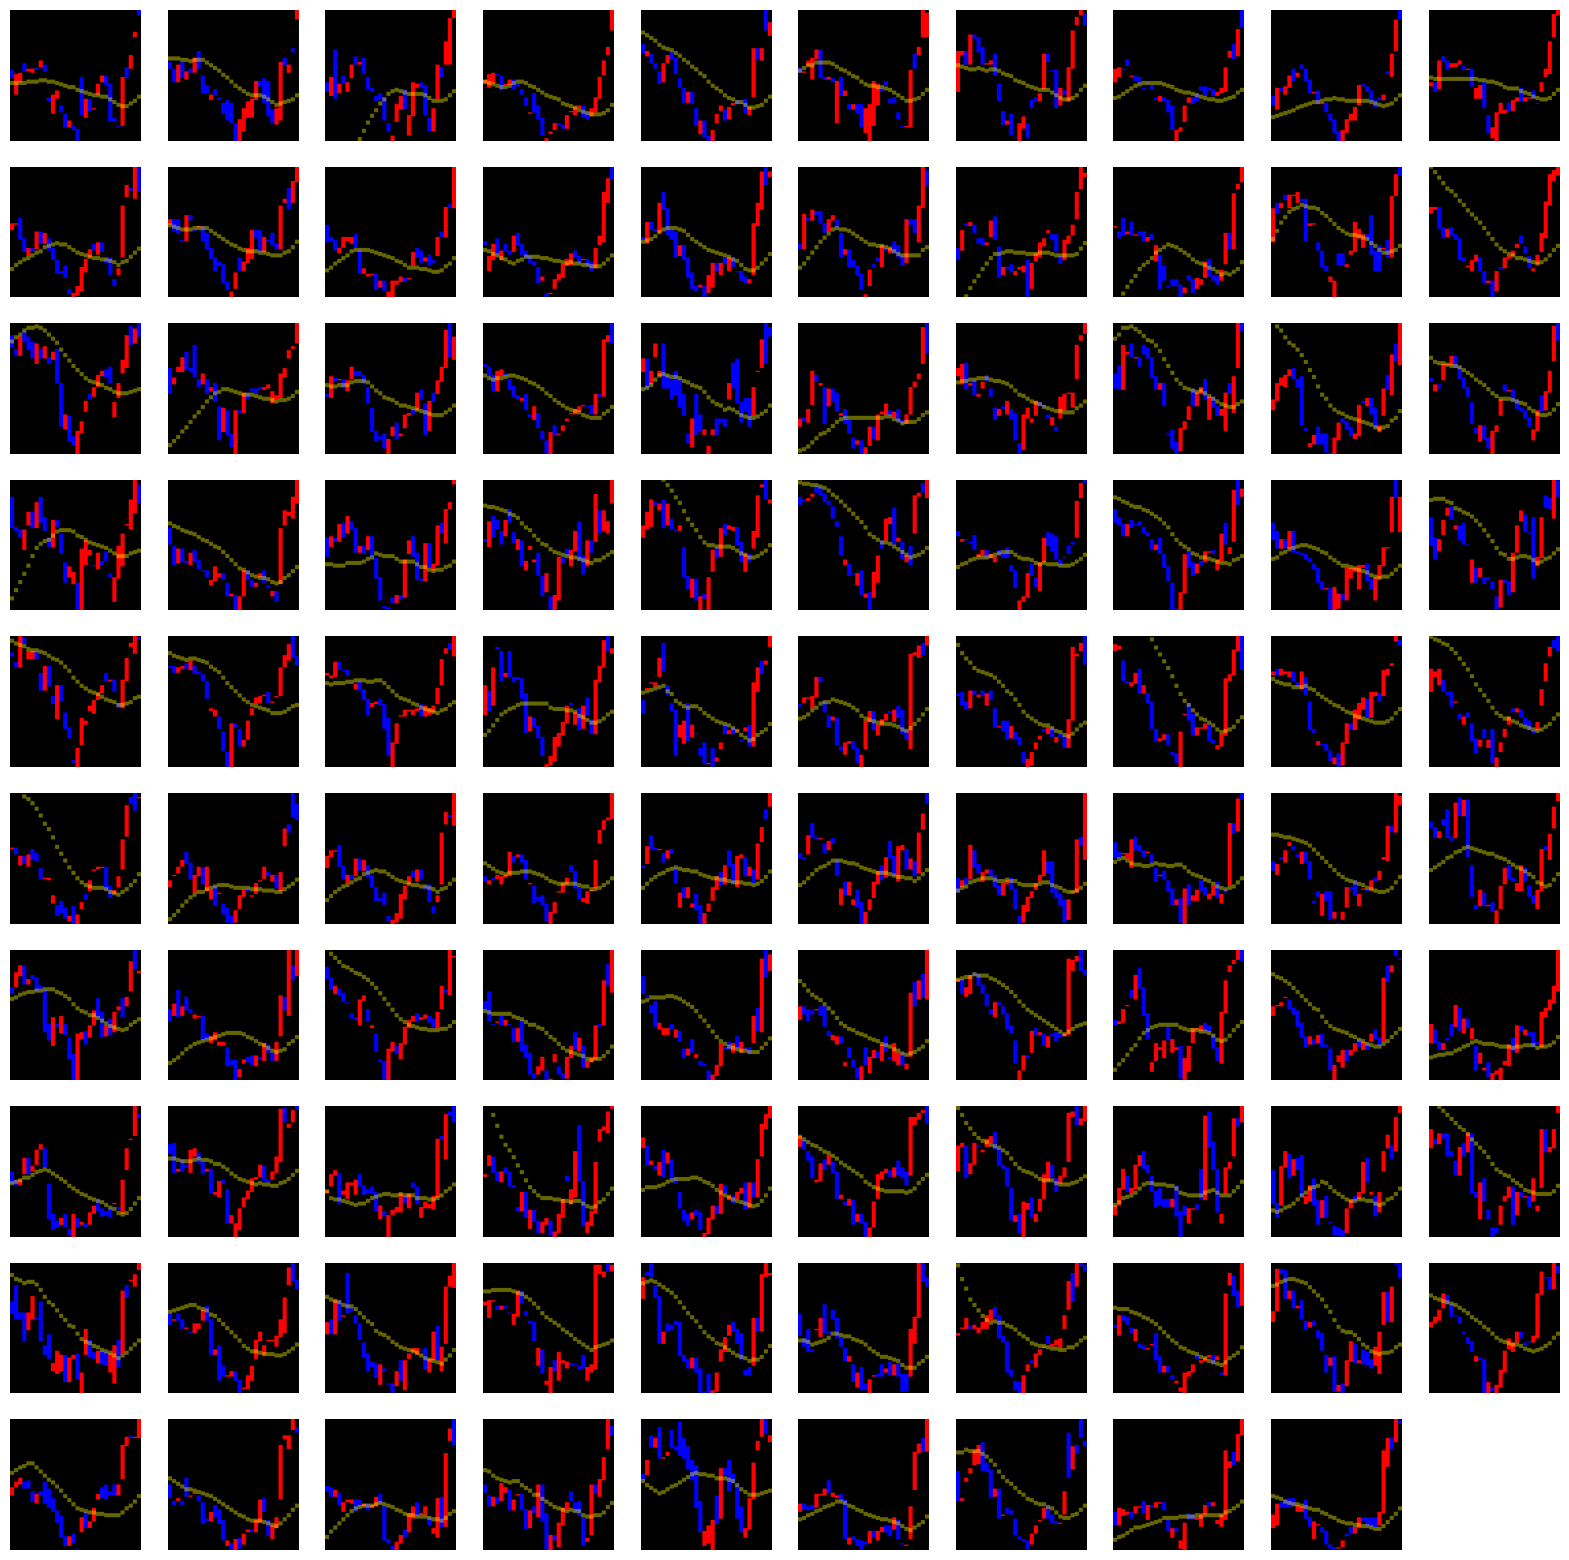

4 AJ네트웍스 2023-09-15
3.864790556230892 카나리아바이오 2021-01-20
3.833058742924689 웰크론한텍 2022-09-15
3.832701678430996 SBS 2022-04-06
3.830976627345173 오리엔탈정공 2021-09-10
3.827407508968958 루트로닉3우C 2018-01-17
3.823957188849479 애경케미칼 2017-04-03
3.822749766635175 대성산업 2019-01-21
3.8172182859396298 에스트래픽 2020-11-17
3.8162257634482017 MDS테크 2014-01-07
3.8148426461766545 세진중공업 2019-04-02
3.8144141419494835 삼양통상 2017-04-03
3.8136955610640024 동성케미컬 2014-05-30
3.8136898453917447 대창 2020-10-22
3.8109600475748393 효성오앤비 2015-03-31
3.8088370220455525 동아에스티 2016-01-07
3.8073219674879004 한솔테크닉스 2013-04-16
3.806855378660646 SK오션플랜트 2020-07-13
3.806373814417029 한익스프레스 2019-01-11
3.806338676008947 토니모리 2022-02-23
3.8058264144075578 엑셈 2020-09-14
3.8053909914254547 올릭스 2020-09-14
3.805336131703041 LG유플러스 2013-04-19
3.805185752219777 STX엔진 2021-10-29
3.8040180312801612 깨끗한나라우 2017-05-16
3.802781661881636 두산에너빌리티 2023-04-18
3.8012633767591533 SIMPAC 2013-11-20
3.7995441842512268 씨큐브 2017-04-19
3.7986366749373133 빛샘전

In [ ]:
import matplotlib.pyplot as plt
import math

latest_image = convert_image(preprocess_data(fdr.DataReader('095570', '2023-03-01')), 1, day_num, '삼성전자', '005930')[0][0]

# result.sort(reverse=True)
# 한 행에 표시될 서브플롯 수 (예: 4개)
cols = 10

# 필요한 행 수 계산
rows = math.ceil(len(similar_images['095570']) / cols)

# 새로운 figure 생성
plt.figure(figsize=(20, rows * 2))

# 모든 유사한 이미지 출력
i = 0
for dif, data in similar_images['095570']:
    plt.subplot(rows, cols, i+1)
    plt.imshow(data.image)
    plt.axis('off')  # 축 제거
    i += 1

plt.show()
for dif, data in similar_images['095570']:
    print(dif, data.name, data.date)

In [ ]:
similar_images[5][0][1]

'DSR'